# 프로젝트10 - 번역기를 만들어보자

# Step1. 필요한 라이브러리 불러오기

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

# Step2. 데이터 불러오기
여기서 사용할 데이터는 https://www.manythings.org/anki 에서 받아오고,프랑스어와 영어의 병렬 코퍼스를 사용하겠습니다.

In [ ]:
file_path = '/content/drive/MyDrive/Exploration_Data/ex10/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.head()

전체 샘플의 수 : 194513


,eng,fra,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [ ]:
# 세번째 열은 불필요하므로 제거해줍니다.
lines = lines[['eng', 'fra']]
lines.head()

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


## 결측치 & 중복치 확인 및 제거

In [ ]:
# 중복치
sum(lines.duplicated('eng'))

57997

In [ ]:
# 결측치
sum(lines.eng.isnull())

0

결측치는 없지만 중복치가 꽤나 많습니다. 제거해 봅시다.

In [ ]:
lines.drop_duplicates(['eng'],inplace=True)
sum(lines.duplicated('eng'))

0

데이터프레임의 인덱스를 0부터 차례대로 바꿔줍시다.

In [ ]:
lines.index = np.arange(len(lines))
lines

,eng,fra
0,Go.,Va !
1,Hi.,Salut !
2,Run!,Cours !
3,Run.,Cours !
4,Who?,Qui ?
...,...,...
136511,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
136512,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
136513,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
136514,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [ ]:
# 학습과 테스트시의 원할한 진행을 위해 데이터에서 상위 33,000개의 샘플만 사용합니다.
# 그리고 앞쪽 인덱스는 보통 짧은 문장 혹은 단어들이 많이 분포하기때문에 높은 인덱스부터 슬라이싱을 해줍니다.
lines = lines[['eng', 'fra']][17000:50000]
lines.sample(5)

,eng,fra
34206,Can you do a headstand?,Sais-tu te tenir sur la tête ?
28298,Tom failed miserably.,Tom a échoué lamentablement.
23961,Tom never came back.,Tom ne revint jamais.
40463,I may swim in the river.,Je peux nager dans la rivière.
26656,I'll be gone all day.,Je serai absent toute la journée.


# Step3. 데이터 전처리
 - ## 구두점(Punctuation)분리
띄어쓰기 단위로 토큰화를 진행하기때문에, 단어에 붙어있는 구두점을 분리시켜줍니다.

In [ ]:
# 영어문장 구두점분리
i=17000
for line in lines['eng']:
  lines_re = []
  for c in line:
    if c not in ['!','?',',','.']:
      lines_re.append(c)
    else:
      lines_re.append(' '+c)

  lines['eng'][i] = ''.join(lines_re)
  i+=1

# 프랑스문장 구두점분리
i=17000
for line in lines['fra']:
  lines_re = []
  for c in line:
    if c not in ['!','?',',','.']:
      lines_re.append(c)
    else:
      lines_re.append(' '+c)

  lines['fra'][i] = ''.join(lines_re)
  i+=1

lines.sample(5)

,eng,fra
34158,Both Tom and I said no .,Tom et moi avons dit non .
29723,Do you miss your kids ?,Est-ce que tes enfants te manquent ?
46449,It is really nice of you .,C'est très gentil de ta part .
43284,What do you believe now ?,Que croyez-vous à présent ?
29188,You are a workaholic .,Tu es un maniaque du travail .


  - ## 소문자로 변경

기계는 대문자와 소문자를 구분하기때문에 Good과 good을 다르게 인식합니다. 따라서 모든 문장을 소문자로 바꿔줍시다.

In [ ]:
for i in range(17000,50000):
  lines.eng[i] = lines.eng[i].lower()
  lines.fra[i] = lines.fra[i].lower()

lines.sample(5)

,eng,fra
34451,don't quote me on that .,sans garantie .
46984,she disliked her husband .,elle n'avait pas d'affinité avec son mari .
40203,i had a run of bad luck .,j'ai eu une série de malchances .
36750,my throat is a bit dry .,ma gorge est un peu sèche .
36039,i'm angry at everybody .,je suis en colère contre tout le monde .


 - ## 디코더의 문장에 시작 토큰과 종료 토큰 추가
seq2seq동작을 위해서 디코더의 입력과 예측에는 시작토큰\<sos>와 종료토큰\<eos>가 필요합니다.

In [ ]:
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
lines.fra.sample(5)

40273    \t je n’ai pas de monnaie sur moi . \n
31263           \t j'étais de bonne humeur . \n
44967          \t je lui ai acheté la télé . \n
26719        \t je vais essayer de t'aider . \n
28285            \t tom a bâclé le travail . \n
Name: fra, dtype: object

# Step4. 토큰화

이제 각 단어장을 만들고, 토큰화를 진행해봅시다. 

In [ ]:
# 영어단어장
eng_tokenizer = Tokenizer(filters='',char_level=False)
eng_tokenizer.fit_on_texts(lines.eng) # 입력받은 문자열 데이터를 리스트로 저장
input_text = eng_tokenizer.texts_to_sequences(lines.eng)             
input_text[100:103]

[[1655, 159, 1], [676, 16, 5, 586, 1], [724, 12, 8, 16, 1]]

In [ ]:
# 프랑스 단어장
fra_tokenizer = Tokenizer(filters='',char_level=False)  
fra_tokenizer.fit_on_texts(lines.fra)          
target_text =  fra_tokenizer.texts_to_sequences(lines.fra)    
target_text[:3]

[[1, 10, 256, 6, 16, 247, 301, 3, 2],
 [1, 10, 123, 6, 129, 1792, 4078, 3, 2],
 [1, 10, 256, 6, 16, 6038, 3, 2]]

In [ ]:
print(eng_tokenizer.word_index)
print(fra_tokenizer.word_index)

{'.': 1, 'i': 2, '?': 3, 'you': 4, 'a': 5, 'is': 6, 'the': 7, 'to': 8, 'tom': 9, 'he': 10, 'it': 11, 'that': 12, 'this': 13, 'do': 14, 'was': 15, 'me': 16, 'my': 17, 'have': 18, "i'm": 19, 'we': 20, "don't": 21, 'are': 22, 'not': 23, 'of': 24, 'your': 25, 'what': 26, 'in': 27, 'like': 28, 'be': 29, 'all': 30, 'can': 31, 'did': 32, 'she': 33, "it's": 34, 'for': 35, 'know': 36, 'on': 37, 'want': 38, 'no': 39, ',': 40, 'very': 41, "that's": 42, 'at': 43, 'how': 44, 'they': 45, 'go': 46, "can't": 47, 'his': 48, 'here': 49, 'has': 50, "you're": 51, 'why': 52, 'need': 53, 'good': 54, 'him': 55, "i'll": 56, 'think': 57, 'there': 58, 'with': 59, 'get': 60, 'really': 61, 'out': 62, 'one': 63, 'now': 64, 'just': 65, 'up': 66, 'will': 67, 'an': 68, "we're": 69, 'her': 70, "didn't": 71, 'were': 72, 'help': 73, 'where': 74, 'had': 75, 'got': 76, 'who': 77, 'us': 78, "isn't": 79, 'so': 80, "i've": 81, 'please': 82, 'french': 83, 'time': 84, 'too': 85, 'going': 86, 'see': 87, 'come': 88, "let's": 89,

단어장의 크기를 변수로 저장해줍시다.

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1      
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 6847
프랑스어 단어장의 크기 : 12528


이제 패딩을 씌워주기위해 영어와 프랑스어 데이터의 최대길이를 구해보겠습니다.

In [ ]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 15


인코더와 달리 디코더는 두가지를 준비해야합니다. 하나는 디코더의 출력과 비교해야할 정답데이터로, 다른하나는 디코더의 입력으로 사용하기 위한것입니다. 이때 디코더의 입력은 eos토큰이 필요가없고, 디코더의 출력과 비교할 시퀀스는 sos토큰이 필요가없기때문에 제거해줍니다.

In [ ]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 10, 256, 6, 16, 247, 301, 3], [1, 10, 123, 6, 129, 1792, 4078, 3], [1, 10, 256, 6, 16, 6038, 3]]
[[10, 256, 6, 16, 247, 301, 3, 2], [10, 123, 6, 129, 1792, 4078, 3, 2], [10, 256, 6, 16, 6038, 3, 2]]


## 패딩
이제 패딩을 씌워줍시다.

In [ ]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',encoder_input.shape)
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 9)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


제대로 씌워졌는지 확인해봅시다.

In [ ]:
encoder_input[:3]

array([[  21,   29,    5,  154,  321,    1,    0,    0,    0],
       [  21,   29,    5,  992,    1,    0,    0,    0,    0],
       [  21,   29,    5, 4037,    1,    0,    0,    0,    0]],
      dtype=int32)

## 테스트 데이터 분리

In [ ]:
encoder_input_train = encoder_input[:30000]
decoder_input_train = decoder_input[:30000]
decoder_target_train = decoder_target[:30000]

encoder_input_test = encoder_input[30000:33000]
decoder_input_test = decoder_input[30000:33000]
decoder_target_test = decoder_target[30000:33000]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 9)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 15)


# Step4. Embedding Layer 사용하기
입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화 하겠습니다.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM, Dense

# 인코더 
encoder_inputs = Input(shape=(None,)) # 입력 텐서 정의
enc_emb =  Embedding(eng_vocab_size, 256, input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(units = 256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)


디코더의 출력층을 설계해줍시다.

In [ ]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

# Step5. 모델 구현하기

In [ ]:
from tensorflow.keras.models import Model

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1752832     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    3207168     ['input_2[0][0]']                
                                                                                              

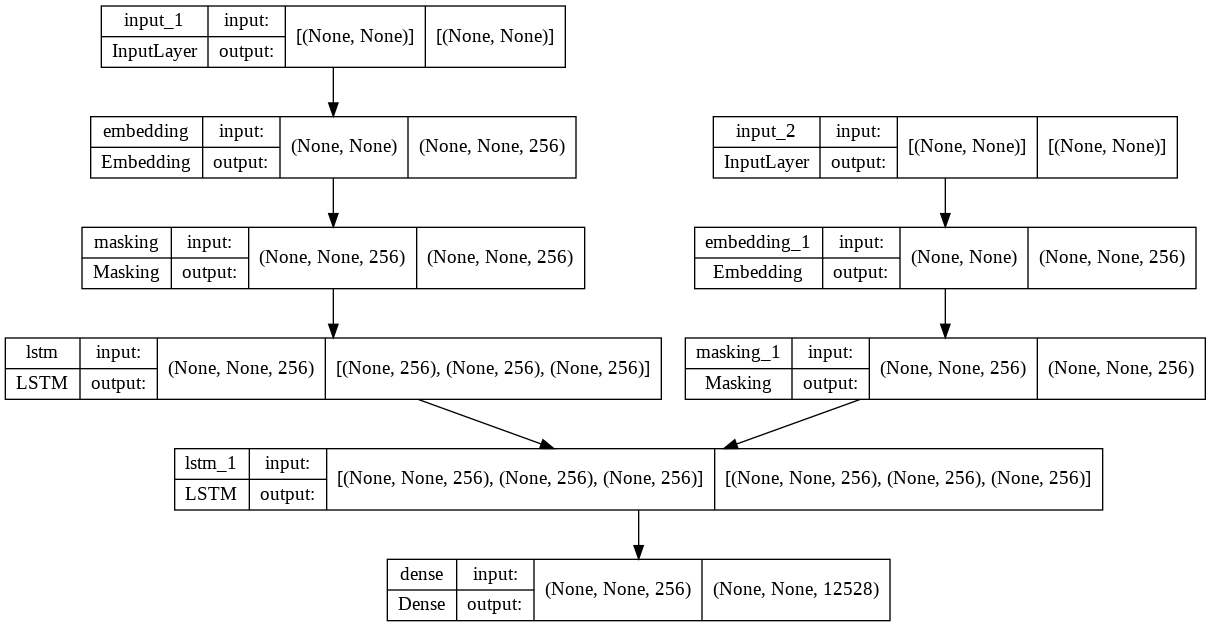

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=20)

Epoch 1/20
235/235 [==============================] - 21s 37ms/step - loss: 2.4592 - val_loss: 2.3384
Epoch 2/20
235/235 [==============================] - 6s 27ms/step - loss: 1.8323 - val_loss: 2.0252
Epoch 3/20
235/235 [==============================] - 6s 27ms/step - loss: 1.6008 - val_loss: 1.8346
Epoch 4/20
235/235 [==============================] - 6s 27ms/step - loss: 1.4499 - val_loss: 1.7409
Epoch 5/20
235/235 [==============================] - 6s 27ms/step - loss: 1.3407 - val_loss: 1.6616
Epoch 6/20
235/235 [==============================] - 6s 27ms/step - loss: 1.2505 - val_loss: 1.6061
Epoch 7/20
235/235 [==============================] - 6s 27ms/step - loss: 1.1738 - val_loss: 1.5450
Epoch 8/20
235/235 [==============================] - 7s 28ms/step - loss: 1.1074 - val_loss: 1.5047
Epoch 9/20
235/235 [==============================] - 7s 28ms/step - loss: 1.0475 - val_loss: 1.4893
Epoch 10/20
235/235 [==============================] - 7s 28ms/step - loss: 0.9933 - val_l

# Step6. 모델 평가하기

In [ ]:
# 인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1752832   
                                                                 
 masking (Masking)           (None, None, 256)         0         
                                                                 
 lstm (LSTM)                 [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 2,278,144
Trainable params: 2,278,144
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb_test = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs_test, state_h_test, state_c_test = decoder_lstm(dec_emb_test, initial_state = decoder_states_inputs)
decoder_states_test = [state_h_test, state_c_test]

In [ ]:
# 디코더 출력층 재설계
decoder_outputs_test = decoder_softmax_layer(decoder_outputs_test)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs_test] + decoder_states_test)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 256)    3207168     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

테스트 결과를 해석하기위해 사전을 준비합시다.

In [ ]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

이제 예측 과정을 위한 함수 decode_sequence()를 구현합니다.

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx['\t']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['\t']) and i!=tar_to_index['\n']):
            temp = temp + index_to_tar[i] + ' '
    return temp

출력 결과를 테스트해봅시다.

In [ ]:
for seq_index in [17000,17050,17100,17300,18001]: 
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_train[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_train[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) 

ValueError: ignored

# 회고
- 데이터를 뽑아보면 중복치가 많이있었다. 예를들어 같은 영어문장이라도 다른 해석이 여러문장이 있는 것이다. 여기서 모든 데이터를 다 가져가면좋지만 해당 익스에서는 30,000개의 데이터만 훈련시키기때문에 최대한 다양한 문장을 훈련시켜주고싶어서 중복치는 전부제거한상태로 훈련을시켜주었다. 이게 도움이 되는지는 사실 모르겠다.
- 처음에 프랑스어말고 한국어로 진행하였는데, 한국어 토큰화의 어려움과 데이터의 턱없이 적은양으로 포기하고 다시 프랑스어로 돌아왔다. 이거때문에 하루를 날렸다...
- 모델을 훈련시켜줄때 계속 shape에러가 떳었다. 도무지 이해가 안갔지만 영태님께 도움을 구한결과 손실함수에 문제가 있었다. 원핫인코딩 유무에따라 손실함수도 고려해주어야한다는것을 깨달았다.
- 처음으로 익스에 실패하였다.. 맨 마지막에서 번역한 문장을 출력하는데 막혔다. 다른 분들것을 참고하면서 내가 어떤 점이 다른지 계속 찾아보았지만 도무지 발견할 수 없었다. 모델 설계는 정말 코드하나하나 비교하면서 봤지만 잘못된점을 찾지못했다. 그래서 아마 전처리에 문제가 있지않을까?라고 추측은해보지만, 단어사전도 잘 뽑혔고 시퀀스도 잘 뽑아냈었다. 도무지 모르겠다..! 분명 어디선가 코드를 잘못쓴게 분명한데.. 다른 분들것을 복사 붙여넣기해서 어떻게든 결과를 뽑아낼수있겠지만, 그것보다는 실패한 이 상태로 그대로 놔두어 좀 NLP에대한 이해도가 쌓였을때 그때 다시 이 익스를 보면 발견할 수 도있고, 만약 발견한다면 상당히 재밌을것같다. I'll be back....